These are TODO's from the EDA section to be implemented in the present notebook.
- FEATURE: replace zipcodes with respective mean longitude and latitude
- FEATURE: replace states with respective mean longitude and latitude
- FEATURE: area of each area could be added, along with density of panels for the given zip code 
- FEATURE: approximation of zipcode by first 2 digits 
- FEATURE: add aditional feature to mark US and non-US states
- FEATURE: merge Puerto Rico states into 1 state


- NULLS: drop nulls 

- SCALING: scaling num of panels group of features is required. Simply dividing by a constant to bring the mean of distribution closer to other features or normalising by mean could be attempted

# Table of Contents
- **[Data initiation](#1)** 
- **[Feature extraction](#2)** 
- **[Feature transformation](#3)** 
- **[Nulls](#4)**
- **[Saving output](#5)**

In [135]:
!pipenv install category_encoders

Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.
Creating a Pipfile for this project...
Installing category_encoders...
Adding category_encoders to Pipfile's [packages]...
✔ Installation Succeeded 
Pipfile.lock not found, creating...
Locking [packages] dependencies...
Building requirements...
Resolving dependencies...
✔ Success! 
Locking [dev-packages] dependencies...
Updated Pipfile.lock (b8ea0db9d4077fca29e581c36181e388e8ad58e373b1dff2c8c1220b160b6f19)!
Installing dependencies from Pipfile.lock (0b6f19)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

<a name='1'></a>
# Data initiation

In [2]:
init_df = pd.read_csv('datasets/geo_solar_panels.csv')                                              # reading initial df
state_accronyms = pd.read_csv('datasets/states_accro_mapping.csv', sep=';')                         # reading df with states accronyms
ref_df =  pd.read_csv('datasets/zip_code_database.csv')[['zip', 'state', 'latitude', 'longitude']]  # reading reference df sourced from www.unitedstateszipcodes.org
ref_df = ref_df.merge(state_accronyms, how='left', left_on='state', right_on='Accro') \
    [['zip', 'latitude', 'longitude', 'State']].rename(columns={'State': 'state'})                  # replacing accronyms with full state named in reference df

US_STATES = list(ref_df['state'].dropna().unique())

In [3]:
# constants

# coordinates of edge points of the Baja California State, 
# scraped from google maps because data for it is not available in the reference dataset
V_MAX = (32.6075076203434, -116.17031418367016)
V_MIN = (28.003118432017647, -113.53742601660399)
H_MIN = (32.00112326006394, -116.86791151884898)
H_MAX = (32.55026231739979, -114.82663290447606)

# fraction of state size to be used as aproximate state radius
RAD_FRACTION = .75

<a name='2'></a>
# Feature extraction

In [4]:
class FeatureExtractor:
    """
    Class to extract additional features. 
    Each method except private outputs one ore several columns to be merged to the initial df by index or other columns.
    """
    def __init__(self, long_min: pd.Series, long_max: pd.Series, lat_min: pd.Series, lat_max: pd.Series,
                 num_of_panels: pd.Series, usa_states: list[str], states_to_check: pd.Series, init_zips: pd.Series,
                 ref_df: pd.DataFrame, init_df_zip_col: str, init_df_state_col: str,
                 ref_df_zip_col: str, ref_df_lat_col: str, ref_df_long_col: str, ref_df_state_col: str, rad_fraction: float = RAD_FRACTION
                 ):
        
        self.long_min = long_min
        self.long_max = long_max
        self.lat_min = lat_min
        self.lat_max = lat_max

        self.num_of_panels = num_of_panels
        self.usa_states = usa_states
        self.states_to_check = states_to_check
        self.init_zips = init_zips
        
        self.init_df_zip_col = init_df_zip_col
        self.init_df_state_col = init_df_state_col

        self.ref_df = ref_df
        self.ref_df_zip_col = ref_df_zip_col
        self.ref_df_lat_col = ref_df_lat_col
        self.ref_df_long_col = ref_df_long_col
        self.ref_df_state_col = ref_df_state_col

        self.rad_fraction = rad_fraction

    def calc_mean_coords(self) -> tuple[pd.Series, pd.Series]:
        """Function calculates mean coordinates for a zip code"""
        lat_mean = (self.lat_max + self.lat_min) / 2
        long_mean = (self.long_max + self.long_min) / 2
        return lat_mean, long_mean

    def calc_zip_area(self) -> pd.Series:
        """The function calculates approx. area of zip code using min/max longitude and lattitude"""
        # adding small number to avoid zero area
        return abs(self.long_max - self.long_min) * abs(self.lat_max - self.lat_min) + .1
    
    def panels_density(self, zip_area: pd.Series) -> pd.Series:
        """Function calculates panels density in a zip_code based on zip_code area and number of panels for the zip_code"""
        return self.num_of_panels / zip_area
    
    def approx_zips(self) -> pd.Series:
        """Function returns a column with first 2 digits of zipcode given a columns of zipcodes"""
        return self.init_zips.astype('str').apply(lambda x: int(x[:2]))
    
    def mask_usa_states(self) -> pd.Series:
        """Function checks if states in the passed column are USA states"""
        return (self.states_to_check.isin(self.usa_states)).astype(int)
    
    def merge_pr_states(self) -> pd.Series:
        """Function replaces smaller Puerto Rico states with a single larger state"""
        local_states = self.states_to_check.copy()
        local_states.loc[(~local_states.isin(self.usa_states)) & (local_states!='Baja California')] = 'Puerto Rico'
        return local_states

    def zips_replacement(self, lat_long_zip_df: pd.DataFrame, 
                         init_df_mean_lat_col: str, init_df_mean_long_col: str) -> tuple[pd.Series, pd.Series]:
        """
        Function merged reference df to the provided df with lat and long and returns mean lat and long with the same index. 
        For zips with no records in the reference df, values are filled with mean coordinates from the original df.
        """
        local_df = lat_long_zip_df.merge(ref_df, how='left', left_on=self.init_df_zip_col, right_on=self.ref_df_zip_col)
        zip_lat = local_df[self.ref_df_lat_col].fillna(value=local_df[init_df_mean_lat_col])
        zip_long = local_df[self.ref_df_long_col].fillna(value=local_df[init_df_mean_long_col])
        return zip_lat, zip_long

    def __find_state_dim_centr(self, grouped_df: pd.DataFrame) -> pd.Series:
        """
        Private function that is used to calculate approximate radius and coordinates of centroids of state in the passed dataset.
        Input dataset should contain data for one state only.
        Output is pd.Series for the function to be used within pd.apply clause.
        """

        if (grouped_df.empty) | (grouped_df.shape[0] < 2): return pd.Series({'state_size': 0, 'centr_lat': 0, 'centr_long': 0})
        edge_points = grouped_df.loc[                                                               # sampling points along 4 edges of a state (N, S, E, W)
            (grouped_df[self.ref_df_lat_col]==max(grouped_df[self.ref_df_lat_col])) | 
            (grouped_df[self.ref_df_lat_col]==min(grouped_df[self.ref_df_lat_col])) |
            (grouped_df[self.ref_df_long_col]==max(grouped_df[self.ref_df_long_col])) | 
            (grouped_df[self.ref_df_long_col]==min(grouped_df[self.ref_df_long_col])) , :
        ][[self.ref_df_lat_col, self.ref_df_long_col]]
        if (edge_points.empty) | (edge_points.shape[0]<2): return pd.Series({'state_size': 0, 'centr_lat': 0, 'centr_long': 0})
        state_size = 0                                                                              # state_size is max Euclidian distance between sampled points
        for dimension in [self.ref_df_lat_col, self.ref_df_long_col]:
            dim_points = edge_points.loc[(edge_points[dimension]==max(edge_points[dimension])) |    # arranging data from sampled rows into 2 2d vectors
                                        (edge_points[dimension]==min(edge_points[dimension])), :].drop_duplicates(dimension).values
            state_size = max([state_size, np.linalg.norm(dim_points[0] - dim_points[1])])                # calculating max Euclidian distance between 2 2d vectors
        return pd.Series({'state_size': self.rad_fraction * state_size,                                     # approximate radius
                          'state_lat': grouped_df[self.ref_df_lat_col].sum() / grouped_df.shape[0],         # centroid latitude
                          'state_long': grouped_df[self.ref_df_long_col].sum() / grouped_df.shape[0]})      # centroid longitude
    
    def calc_centr_size(self) -> pd.DataFrame:
        """
        Function applies find_state_dim_centr function to the reference df and returns dataset with 3 columns: 
        state_size, mean state latitude, mean state longitude.
        """
        return self.ref_df[[self.ref_df_state_col, self.ref_df_lat_col, self.ref_df_long_col]][(self.ref_df[self.ref_df_lat_col]!=0)] \
                                    .dropna() \
                                    .groupby(self.ref_df_state_col) \
                                    .apply(self.__find_state_dim_centr)
    
    def clac_baja_ca_centr_size(self, v_max: tuple[float, float], v_min: tuple[float, float], 
                                      h_min: tuple[float, float], h_max: tuple[float, float]):
        """Function calculates centroid and size for Baja California state specifically"""
        vert_points = np.array([v_max, v_min])
        horiz_points = np.array([h_max, h_min])
        state_size = max([np.linalg.norm(vert_points[0] - vert_points[1]), 
                          np.linalg.norm(horiz_points[0] - horiz_points[1])])

        return {'state_size': state_size,
                'state_lat': (v_max[0] + v_min[0]) / 2,
                'state_long': (h_min[1] + h_max[1]) / 2}

In [5]:
extr = FeatureExtractor(
    long_min=init_df['long_min'],
    long_max=init_df['long_max'],
    lat_min=init_df['lat_min'],
    lat_max=init_df['lat_max'],
    init_zips=init_df['zip_code'],
    num_of_panels=init_df['number_of_panels_total'],
    usa_states=US_STATES,
    states_to_check=init_df['state'],
    ref_df=ref_df,
    init_df_zip_col='zip_code',
    init_df_state_col = 'state',
    ref_df_zip_col='zip',
    ref_df_lat_col='latitude',
    ref_df_long_col='longitude',
    ref_df_state_col='state'
)

In [6]:
init_df.loc[:, 'lat_mean'], init_df.loc[:, 'long_mean'] = extr.calc_mean_coords()
init_df['zip_area'] = extr.calc_zip_area()
init_df['dens'] = extr.panels_density(zip_area=init_df['zip_area'])
init_df['approx_zips'] = extr.approx_zips()
init_df['is_usa'] = extr.mask_usa_states()
init_df.loc[:, 'zip_lat'], init_df.loc[:, 'zip_long'] = extr.zips_replacement(lat_long_zip_df=init_df[['lat_mean', 'long_mean', 'zip_code']].copy(),
                                                                              init_df_mean_lat_col='lat_mean',
                                                                              init_df_mean_long_col='long_mean')

init_df.loc[:, 'state'] = extr.merge_pr_states()
init_df = init_df.merge(extr.calc_centr_size(), on='state', how='left')
baja_params = extr.clac_baja_ca_centr_size(v_max=V_MAX, v_min=V_MIN, h_min=H_MIN, h_max=H_MAX)
for col in baja_params:
    init_df.loc[init_df['state']=='Baja California', col] = baja_params[col]

In [30]:
sav_cols = [
    'lat_max',
    'lat_min',
    'long_max',
    'long_min',
    'number_of_panels_north',
    'number_of_panels_south',
    'number_of_panels_east',
    'number_of_panels_west',
    'number_of_panels_flat',
    'number_of_panels_total',
    'potential_kwh_total',
    'lat_mean',
    'long_mean',
    'zip_area',
    'dens',
    'approx_zips',
    'is_usa',
    'zip_lat',
    'zip_long',
    'state_size',
    'state_lat',
    'state_long'
]
normed_init_df = init_df[sav_cols].copy()
normed_init_df.loc[:, 'is_usa'] = ce.LeaveOneOutEncoder().fit_transform(normed_init_df['is_usa'].astype('category'), normed_init_df['potential_kwh_total'])

sc = RobustScaler()
scaled_cols = ['scaled_' + el for el in list(normed_init_df)]
normed_init_df = pd.DataFrame(sc.fit_transform(X=normed_init_df.values, y=None), 
                              columns=scaled_cols, index=normed_init_df.index)

(-10.0, 10.0)

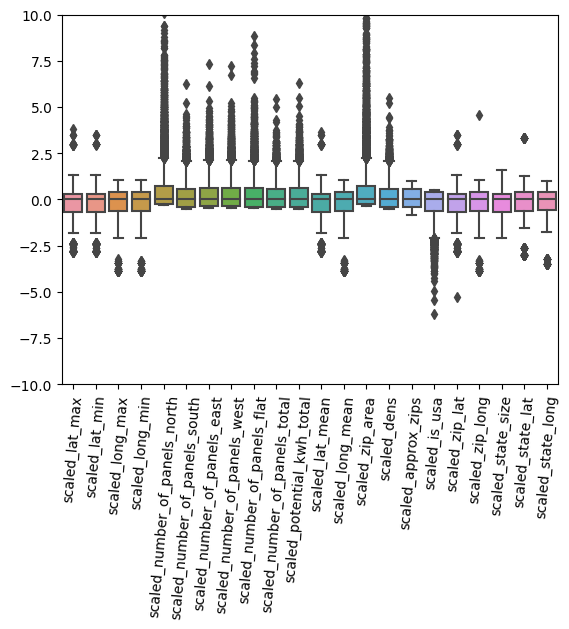

In [31]:
# normed_init_df
sns.boxplot(normed_init_df)
plt.xticks(rotation = 85)
plt.ylim(-10,10)

In [33]:
normed_init_df.dropna().reset_index(drop=True).to_csv('datasets/small_modeling_df.csv', index=False)

### Manual scaling

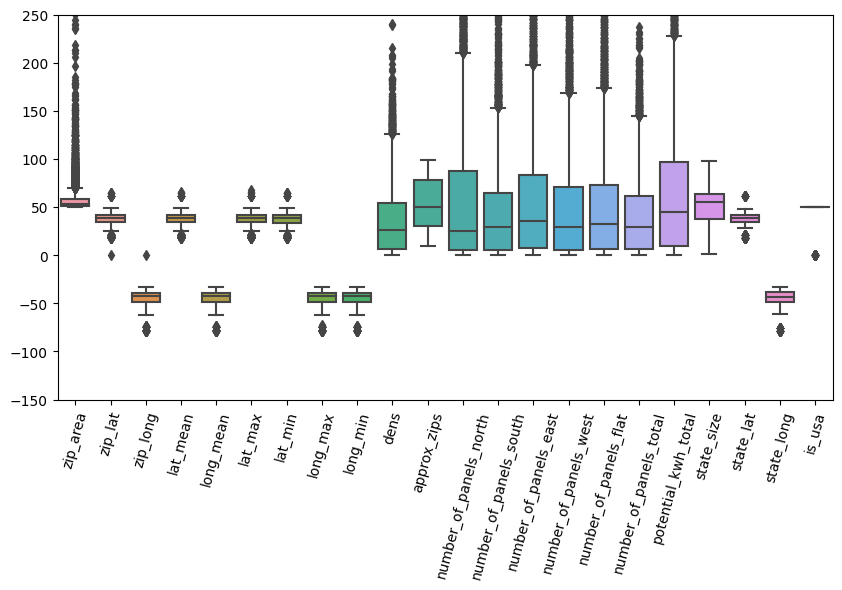

In [42]:
# We do scaling b/c linear model will be attempted to fit to data.
# Manual scaling is done here as a draft using all available data. 
# Normally scaling multipliers need to be determined based on training data only and then applied to test data. 

feats_to_scale = ['zip_area', 'zip_lat', 'zip_long', 'lat_mean', 'long_mean', 'lat_max', 'lat_min', 'long_max', 'long_min', 'dens', 'approx_zips',
                  'number_of_panels_north', 'number_of_panels_south', 'number_of_panels_east', 'number_of_panels_west', 'number_of_panels_flat', 
                  'number_of_panels_total', 'potential_kwh_total', 'state_size', 'state_lat', 'state_long', 'is_usa']

mults = {
    'dens': 1e-5,
    'zip_area': 5e2,
    'zip_long': .5,
    'long_mean': .5,
    'number_of_panels_north': 3e-3,
    'number_of_panels_south': 5e-4,
    'number_of_panels_east': 1e-3,
    'number_of_panels_west': 7e-4,
    'number_of_panels_flat': 3e-4,
    'number_of_panels_total': 1e-4,
    'potential_kwh_total': 5e-7,
    'long_min': .5,
    'long_max': .5,
    'state_long': .5,
    'state_size': 10,
    'is_usa': 50
}

def apply_mults(df: pd.DataFrame, mults: dict) -> pd.DataFrame:
    """Function applies multipliers from the passed dict to respective columns of the passed df"""
    local_df = df.copy()
    for k in mults:
        local_df.loc[:, k] = local_df[k] * mults[k]
    return local_df

scaled_df = apply_mults(init_df, mults)

plt.figure(figsize=[10, 5])
sns.boxplot(scaled_df[feats_to_scale])
plt.ylim(bottom=-150, top=250); plt.xticks(rotation=75);

In [45]:
# saving before scaling
init_df[feats_to_scale].dropna().reset_index(drop=True).to_csv('datasets/prescaled_modeling_df.csv', index=False)

# saving after scaling
scaled_df[feats_to_scale].dropna().reset_index(drop=True).to_csv('datasets/scaled_modeling_df.csv', index=False)

<a name='3'></a>
# Feature transformation

In [7]:
    class FeatureTransformer:
        """Class to transform continuous, categorical features and label"""
        def __init__(self, cont_feats: pd.DataFrame, cat_feats: pd.DataFrame):
            self.cont_feats = cont_feats
            self.cat_feats = cat_feats
        
        def cat_transform(self, label):
            """Function does categorical features transformation over passed df"""
            return ce.LeaveOneOutEncoder().fit_transform(self.cat_feats.copy(), label)

        def cont_transform(self):
            """Function performs scaling, quantile binning and extraction of PCA representation over passed continuous features"""
            local = self.cont_feats.copy()
            
            # scaling
            sc = RobustScaler()
            scaled_cols = ['scaled_' + el for el in list(local)]
            local = pd.DataFrame(sc.fit_transform(X=local.values, y=None), 
                                 columns=scaled_cols, index=local.index)
            #PCA
            pca_cols = ['pca_' + str(el) for el in range(1, local.shape[1]+1)]
            pca = PCA().fit(local.fillna(0))
            local = local.join(pd.DataFrame(pca.transform(local.fillna(0)), 
                               columns=pca_cols, index=local.index))
            # quantile binning
            qt = QuantileTransformer(n_quantiles=20)
            binned = pd.DataFrame(qt.fit_transform(local[scaled_cols].values), 
                                  columns=['binned_' + el for el in scaled_cols],
                                  index=self.cont_feats.index)
            local = local.join(binned)
            return local

        def label_transform(self, label):
            """Function is used to transform continuous label"""
            sc = RobustScaler()
            return sc.fit_transform(X=label.reshape(-1, 1), y=None)

In [8]:
# here we process `approx_zips` feature as both continuous and categorical because of it's inherent duality
cont_feats = [
    'lat_max',
    'lat_min',
    'lat_mean',
    'long_max',
    'long_min',
    'long_mean',
    'zip_area',
    'dens',
    'approx_zips',
    'zip_lat',
    'zip_long',
    'state_size',
    'state_lat',
    'state_long',
    'number_of_panels_north',
    'number_of_panels_south',
    'number_of_panels_east',
    'number_of_panels_west',
    'number_of_panels_flat',
    'number_of_panels_total'
]
cat_feats = [
    'is_usa',
    'state',
    'approx_zips'
]

In [9]:
feat_trans = FeatureTransformer(cont_feats=init_df[cont_feats], cat_feats=init_df[cat_feats].astype('category'))

transformed_df = feat_trans.cont_transform()
transformed_df.loc[:, 'scaled_label'] = feat_trans.label_transform(label=init_df['potential_kwh_total'].values)
transformed_df = transformed_df.join(feat_trans.cat_transform(label=transformed_df['scaled_label'].values))

In [10]:
transformed_df

,scaled_lat_max,scaled_lat_min,scaled_lat_mean,scaled_long_max,scaled_long_min,scaled_long_mean,scaled_zip_area,scaled_dens,scaled_approx_zips,scaled_zip_lat,...,binned_scaled_number_of_panels_north,binned_scaled_number_of_panels_south,binned_scaled_number_of_panels_east,binned_scaled_number_of_panels_west,binned_scaled_number_of_panels_flat,binned_scaled_number_of_panels_total,scaled_label,is_usa,state,approx_zips
0,-0.020316,-0.014881,-0.017585,0.460471,0.462899,0.461925,-0.221958,0.166740,-0.6250,-0.017520,...,0.249281,0.257566,0.282002,0.265099,0.825434,0.547994,0.095444,0.225900,-0.349379,-0.174992
1,-0.025023,-0.018306,-0.021651,0.459582,0.462839,0.461450,-0.286819,-0.274973,-0.6250,-0.021563,...,0.237873,0.236646,0.241790,0.253766,0.482410,0.323998,-0.289062,0.225933,-0.339520,-0.172304
2,-0.019997,-0.014661,-0.017315,0.457520,0.462044,0.460021,-0.317407,-0.202309,-0.6250,-0.017520,...,0.299440,0.230014,0.252161,0.259872,0.556485,0.361709,-0.229873,0.225928,-0.341037,-0.172717
3,-0.018841,-0.009639,-0.014228,0.457295,0.461029,0.459401,-0.343583,-0.311031,-0.6250,-0.014825,...,0.316785,0.217492,0.210885,0.199636,0.456743,0.302282,-0.321293,0.225936,-0.338693,-0.172078
4,-0.014574,-0.009038,-0.011793,0.458625,0.461006,0.460055,-0.222489,0.181011,-0.6250,-0.012129,...,0.543907,0.466869,0.416919,0.404869,0.741130,0.554271,0.103848,0.225899,-0.349594,-0.175051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11504,-0.682501,-0.673286,-0.677777,0.241833,0.247140,0.244704,-0.364228,-0.532874,-0.4375,-0.679245,...,0.000000,0.002915,0.000000,0.000000,0.082922,0.039421,-0.507633,0.225953,0.276808,0.251355
11505,-0.678763,-0.669541,-0.674037,0.238857,0.244162,0.241727,-0.364228,-0.534953,-0.4375,-0.679245,...,0.000000,0.000000,0.000000,0.000000,0.022594,0.003450,-0.509477,0.225953,0.276818,0.251364
11506,-0.565197,-0.555762,-0.560382,0.171543,0.176780,0.174372,-0.364228,-0.532666,-0.4375,-0.561995,...,0.000000,0.000000,0.000000,0.000000,0.086630,0.043014,-0.507402,0.225953,0.276807,0.251354
11507,-0.900931,-0.909165,-0.904888,0.255224,0.249978,0.252822,1.279582,-0.535119,-0.4375,-0.908356,...,0.000000,0.000000,0.000000,0.024570,0.000000,0.000791,-0.509602,0.225953,0.276819,0.251365


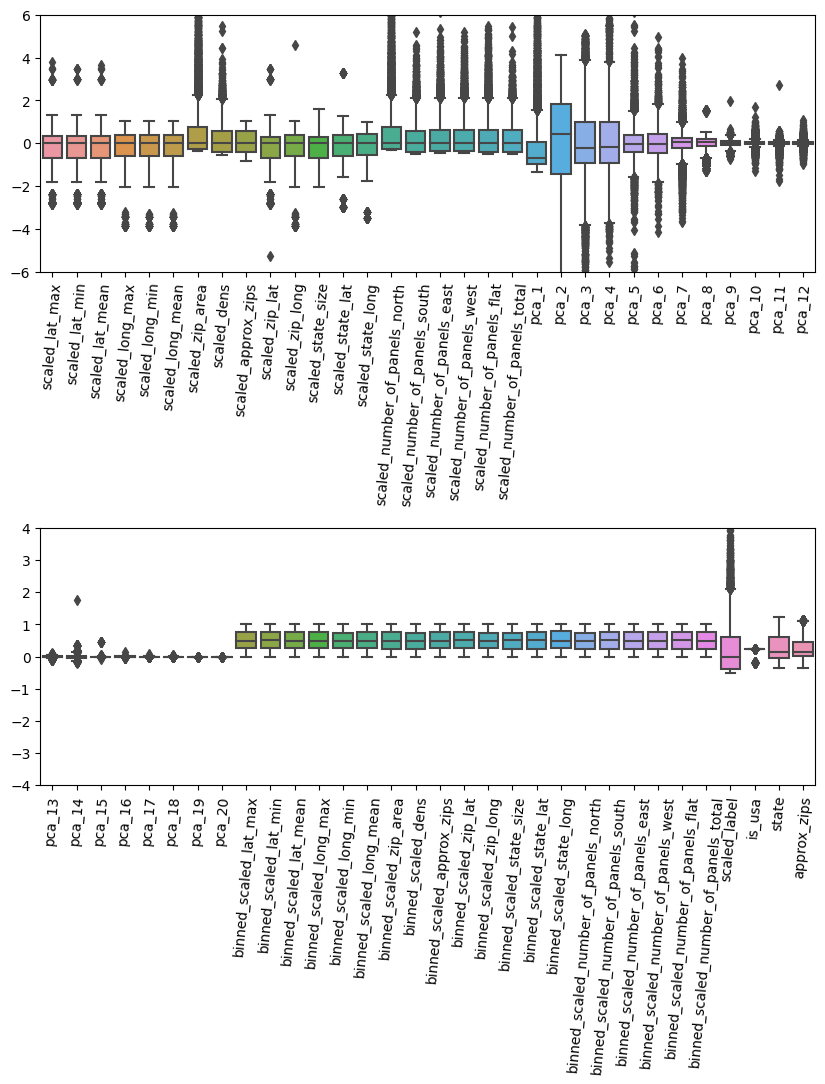

In [11]:
# verifying that all features have similar range of values and means

fig, ax = plt.subplots(2, 1, figsize=[10, 10])
sns.boxplot(transformed_df.iloc[:, :32], ax=ax[0])
sns.boxplot(transformed_df.iloc[:, 32:], ax=ax[1])
ax[0].set_ylim(bottom=-6, top=6); ax[1].set_ylim(bottom=-4, top=4)
ax[0].tick_params(axis="x", labelrotation=85); ax[1].tick_params(axis="x", labelrotation=85)
fig.subplots_adjust(hspace=1, wspace=0)

<a name='4'></a>
# Nulls

In [12]:
# making sure that we still have only 19 nulls, as seen at the EDA stage
sorted(list(zip([transformed_df[col].isna().sum() for col in list(transformed_df)], list(transformed_df))), reverse=True, key=lambda x:x[0])

[(19, 'scaled_dens'),
 (19, 'scaled_number_of_panels_total'),
 (19, 'binned_scaled_dens'),
 (19, 'binned_scaled_number_of_panels_total'),
 (19, 'scaled_label'),
 (19, 'is_usa'),
 (19, 'state'),
 (19, 'approx_zips'),
 (0, 'scaled_lat_max'),
 (0, 'scaled_lat_min'),
 (0, 'scaled_lat_mean'),
 (0, 'scaled_long_max'),
 (0, 'scaled_long_min'),
 (0, 'scaled_long_mean'),
 (0, 'scaled_zip_area'),
 (0, 'scaled_approx_zips'),
 (0, 'scaled_zip_lat'),
 (0, 'scaled_zip_long'),
 (0, 'scaled_state_size'),
 (0, 'scaled_state_lat'),
 (0, 'scaled_state_long'),
 (0, 'scaled_number_of_panels_north'),
 (0, 'scaled_number_of_panels_south'),
 (0, 'scaled_number_of_panels_east'),
 (0, 'scaled_number_of_panels_west'),
 (0, 'scaled_number_of_panels_flat'),
 (0, 'pca_1'),
 (0, 'pca_2'),
 (0, 'pca_3'),
 (0, 'pca_4'),
 (0, 'pca_5'),
 (0, 'pca_6'),
 (0, 'pca_7'),
 (0, 'pca_8'),
 (0, 'pca_9'),
 (0, 'pca_10'),
 (0, 'pca_11'),
 (0, 'pca_12'),
 (0, 'pca_13'),
 (0, 'pca_14'),
 (0, 'pca_15'),
 (0, 'pca_16'),
 (0, 'pca_17')

In [13]:
transformed_df = transformed_df.dropna().reset_index(drop=True)

In [15]:
# verifying that all nans are droped
sum([transformed_df[col].isna().sum() for col in list(transformed_df)]) == 0

True

In [16]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11490 entries, 0 to 11489
Data columns (total 64 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   scaled_lat_max                        11490 non-null  float64
 1   scaled_lat_min                        11490 non-null  float64
 2   scaled_lat_mean                       11490 non-null  float64
 3   scaled_long_max                       11490 non-null  float64
 4   scaled_long_min                       11490 non-null  float64
 5   scaled_long_mean                      11490 non-null  float64
 6   scaled_zip_area                       11490 non-null  float64
 7   scaled_dens                           11490 non-null  float64
 8   scaled_approx_zips                    11490 non-null  float64
 9   scaled_zip_lat                        11490 non-null  float64
 10  scaled_zip_long                       11490 non-null  float64
 11  scaled_state_si

New features as per EDA have been added and all continuous and categorical features have been transformed to float64 format with mean close to 0 and similar range of values. Normally such transformations should be done on training set only, then label predicted and unscaled to compare to the truth vector. Because minimised final score is not the priority, for this excersice we are not using this approach, even though it is correct, to minimise complexity. Outliers are not removed here because it was shown at EDA stage that it is not possible to show that they are errors in the data.

<a name='5'></a>
# Saving output

In [17]:
transformed_df.to_csv('datasets/modeling_df.csv', index=False)